In [137]:
import os
import cv2
import torch
import timm
import random
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2
import albumentations as A
import matplotlib.pyplot as plt

In [138]:
def apply_clahe(img, **kwargs):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

In [139]:
def get_transforms():
    return A.Compose([
        A.Lambda(image=apply_clahe),
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

In [140]:
class GlaucomaDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.loc[idx, 'image_path'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.loc[idx, 'label']

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label, img_path

In [141]:
def load_transformer_model(model_name, model_path, device):
    if model_name == 'vit_base_patch16_224':
        model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=2)
    elif model_name == 'swin_base_patch4_window7_224':
        model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=2)
    else:
        raise ValueError(f"Unsupported transformer model: {model_name}")

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    return model

In [142]:
def explain_random_image(model, dataset, device, model_name):
    idx = random.randint(0, len(dataset) - 1)
    img_tensor, label, img_path = dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()

    print(f"\nModel: {model_name}")
    print(f"Image: {img_path}")
    print(f"Ground Truth: {label}, Predicted: {pred}")

    mask = attention_rollout(model, input_tensor, device, discard_ratio=0.85, model_name=model_name, use_fallback=True)

    if mask is not None:
        show_attention_map(img_tensor, mask, f"{model_name} Attention Rollout")
    else:
        print("Attention rollout failed.")

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [144]:
labels_df = pd.read_csv("/kaggle/input/unified-dataset/labels.csv")
val_dataset = GlaucomaDataset(labels_df, root_dir="/kaggle/input/unified-dataset", transform=get_transforms())

In [145]:
def patch_attention_modules(model):
    attentions = []

    def patch_block_attn_forward(block):
        original_forward = block.attn.forward

        def new_forward(x):
            B, N, C = x.shape

            qkv = block.attn.qkv(x).reshape(B, N, 3, block.attn.num_heads, C // block.attn.num_heads)
            q, k, v = qkv.permute(2, 0, 3, 1, 4)

            attn = (q @ k.transpose(-2, -1)) * block.attn.scale
            attn = attn.softmax(dim=-1)
            attentions.append(attn.detach().cpu())

            attn = block.attn.attn_drop(attn)

            out = (attn @ v).transpose(1, 2).reshape(B, N, C)
            out = block.attn.proj(out)
            out = block.attn.proj_drop(out)
            return out

        block.attn.forward = new_forward

    if hasattr(model, 'blocks'):
        for block in model.blocks:
            patch_block_attn_forward(block)
    elif hasattr(model, 'layers'):
        for layer in model.layers:
            for block in layer.blocks:
                patch_block_attn_forward(block)
    else:
        print("Unknown model architecture for patching attention.")

    return attentions

# Attention rollout function
def attention_rollout(attentions, discard_ratio=0.9):
    if len(attentions) == 0:
        print("No attentions captured for rollout.")
        return None

    att_matrices = [att.mean(dim=1).squeeze(0).numpy() for att in attentions]
    att_matrices = [att + np.eye(att.shape[0]) for att in att_matrices]
    att_matrices = [att / att.sum(axis=1, keepdims=True) for att in att_matrices]

    rollout = att_matrices[0]
    for att in att_matrices[1:]:
        if rollout.shape[1] != att.shape[0]:
            print(f"Incompatible attention shapes for rollout: {rollout.shape} vs {att.shape}. Using last attention only.")
            rollout = att
            break
        rollout = rollout @ att

    mask = rollout[0, 1:]

    size = int(np.sqrt(mask.shape[0]))
    if size * size != mask.shape[0]:
        print(f"Attention rollout: Cannot reshape mask of size {mask.shape[0]} to square, using 1D mask.")
        mask_2d = None
    else:
        mask_2d = mask.reshape(size, size)

    if mask_2d is not None:
        mask_2d = (mask_2d - mask_2d.min()) / (mask_2d.max() - mask_2d.min() + 1e-8)

    return mask_2d if mask_2d is not None else mask

def show_attention_map(img_tensor, mask, title="Attention Rollout"):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    if len(mask.shape) == 1:
        size = int(np.sqrt(mask.shape[0]))
        if size * size == mask.shape[0]:
            mask = mask.reshape(size, size)
        else:
            mask = cv2.resize(mask.reshape(1, -1), (img.shape[1], img.shape[0]))
        mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)
    else:
        mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = heatmap.astype(np.float32) / 255
    overlay = heatmap + img
    overlay = overlay / np.max(overlay)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(title)
    plt.show()

def explain_random_image_transformer(model, dataset, device, model_name):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    img_tensor, label, img_path = dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()

    print(f"\nModel: {model_name}")
    print(f"Image: {img_path}")
    print(f"Ground Truth: {label}, Predicted: {pred}")

    # Patch the model to capture attention weights
    attentions = patch_attention_modules(model)

    # Forward again to capture attentions
    with torch.no_grad():
        _ = model(input_tensor)

    mask = attention_rollout(attentions, discard_ratio=0.9)
    if mask is not None:
        show_attention_map(img_tensor, mask, title=f"{model_name} Attention Rollout")
    else:
        print("Attention rollout failed.")



Model: vit_base_patch16_224
Image: /kaggle/input/unified-dataset/images/EYEPACS_EyePACS-TRAIN-RG-428.jpg
Ground Truth: 1, Predicted: 1


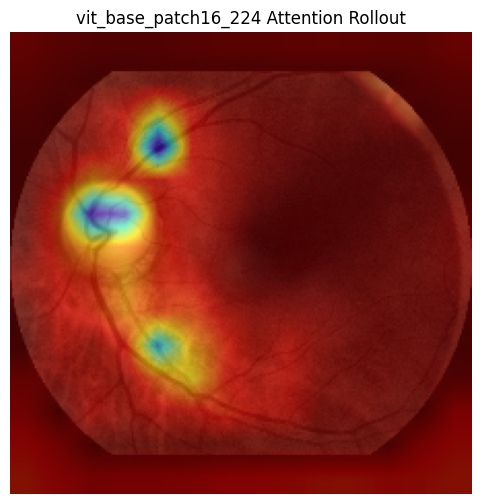

In [146]:
model = load_transformer_model('vit_base_patch16_224', model_path, device)
explain_random_image_transformer(model, val_dataset, device, 'vit_base_patch16_224')


Model: swin_base_patch4_window7_224
Image: /kaggle/input/unified-dataset/images/EYEPACS_EyePACS-TRAIN-RG-429.jpg
Ground Truth: 1, Predicted: 0


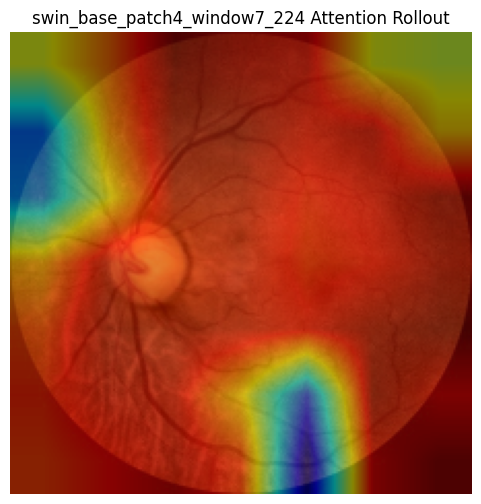

In [148]:
# def apply_clahe(img, **kwargs):
#     lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
#     l, a, b = cv2.split(lab)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     cl = clahe.apply(l)
#     merged = cv2.merge((cl, a, b))
#     return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

# def get_transforms():
#     return A.Compose([
#         A.Lambda(image=apply_clahe),
#         A.Resize(224, 224),
#         A.Normalize(mean=(0.485, 0.456, 0.406),
#                     std=(0.229, 0.224, 0.225)),
#         ToTensorV2()
#     ])

# class GlaucomaDataset(Dataset):
#     def __init__(self, df, root_dir, transform=None):
#         self.df = df.reset_index(drop=True)
#         self.root_dir = root_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.root_dir, self.df.loc[idx, 'image_path'])
#         image = cv2.imread(img_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         label = self.df.loc[idx, 'label']

#         if self.transform:
#             image = self.transform(image=image)['image']

#         return image, label, img_path

def patch_swin_attention_forward(model):
    attentions = []

    def forward_hook(self, x, mask=None):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(0).unsqueeze(0)
            elif mask.dim() == 3:
                mask = mask.unsqueeze(1)
            attn = attn.masked_fill(mask == 0, float('-inf'))

        attn = attn.softmax(dim=-1)
        attn = torch.where(torch.isnan(attn) | torch.isinf(attn), torch.zeros_like(attn), attn)

        attentions.append(attn.detach().cpu())
        attn = self.attn_drop(attn)
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        out = self.proj_drop(out)
        return out

    for layer in model.layers:
        for block in layer.blocks:
            block.attn.forward = forward_hook.__get__(block.attn, block.attn.__class__)
    return attentions

def attention_rollout(attentions, discard_ratio=0.9):
    if len(attentions) == 0:
        print("No attentions captured for rollout.")
        return None

    att_matrices = []
    for att in attentions:
        att_avg_heads = att.mean(dim=1)
        att_avg_batch = att_avg_heads.mean(dim=0)
        att_matrices.append(att_avg_batch.numpy())

    att_matrices = [att + np.eye(att.shape[0], dtype=att.dtype) for att in att_matrices]
    att_matrices = [att / (att.sum(axis=1, keepdims=True) + 1e-8) for att in att_matrices]

    rollout = att_matrices[0]
    for att in att_matrices[1:]:
        if rollout.shape[1] != att.shape[0]:
            print(f"Incompatible attention shapes for rollout: {rollout.shape} vs {att.shape}. Using last attention only.")
            rollout = att
            break
        rollout = rollout @ att

    mask = rollout.mean(axis=0)

    mask = np.where(np.isnan(mask) | np.isinf(mask), 0.0, mask)

    size = int(np.sqrt(mask.shape[0]))
    if size * size != mask.shape[0]:
        print(f"Attention rollout: Cannot reshape mask of size {mask.shape[0]} to square, using 1D mask.")
        mask_2d = None
    else:
        mask_2d = mask.reshape(size, size)

    if mask_2d is not None:
        mask_min, mask_max = mask_2d.min(), mask_2d.max()
        if mask_max == mask_min:
            mask_2d = np.zeros_like(mask_2d)
        else:
            mask_2d = (mask_2d - mask_min) / (mask_max - mask_min + 1e-8)
        mask_2d = np.clip(mask_2d, 0.0, 1.0)
    return mask_2d if mask_2d is not None else mask

def show_attention_map(img_tensor, mask, title="Attention Rollout"):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    if mask.ndim == 1:
        size = int(np.sqrt(mask.shape[0]))
        if size * size == mask.shape[0]:
            mask = mask.reshape(size, size)
        else:
            mask = cv2.resize(mask.reshape(1, -1), (img.shape[1], img.shape[0]))
    else:
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    mask = np.where(np.isnan(mask) | np.isinf(mask), 0.0, mask)
    mask = np.clip(mask, 0.0, 1.0)

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = heatmap.astype(np.float32) / 255
    overlay = heatmap + img
    overlay = overlay / np.max(overlay)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(title)
    plt.show()

def explain_random_image_transformer(model, dataset, device, model_name):
    model.eval()
    attentions = patch_swin_attention_forward(model)

    idx = random.randint(0, len(dataset) - 1)
    img_tensor, label, img_path = dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()

    print(f"\nModel: {model_name}")
    print(f"Image: {img_path}")
    print(f"Ground Truth: {label}, Predicted: {pred}")

    mask = attention_rollout(attentions)
    if mask is not None:
        show_attention_map(img_tensor, mask, title=f"{model_name} Attention Rollout")
    else:
        print("Attention rollout failed.")

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load labels CSV and dataset root directory here:
    labels_csv_path = "/kaggle/input/unified-dataset/labels.csv"  # change this path
    dataset_root_dir = "/kaggle/input/unified-dataset"            # change this path

    labels_df = pd.read_csv(labels_csv_path)
    val_dataset = GlaucomaDataset(labels_df, root_dir=dataset_root_dir, transform=get_transforms())

    # Load your saved checkpoint path here:
    checkpoint_path = "/kaggle/input/transformer_models/pytorch/default/1/swin_base_patch4_window7_224_best.pth"  # change this path

    # Create model architecture (no pretrained weights)
    model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=2)

    model.to(device)

    # Load checkpoint weights
    checkpoint = torch.load(checkpoint_path, map_location=device)

    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint

    # Fix possible 'module.' prefix
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_key = k[7:]
        else:
            new_key = k
        new_state_dict[new_key] = v

    model.load_state_dict(new_state_dict)
    model.eval()

    explain_random_image_transformer(model, val_dataset, device, 'swin_base_patch4_window7_224')

if __name__ == "__main__":
    main()